In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

#Data Loading and preprocessing

In [ ]:
# Dataset
import zipfile

z = zipfile.ZipFile('/kaggle/archive.zip')

z.extractall()

In [ ]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [ ]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


# EDA(Exploratory Data Analysis)

In [ ]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


In [ ]:
# Plot

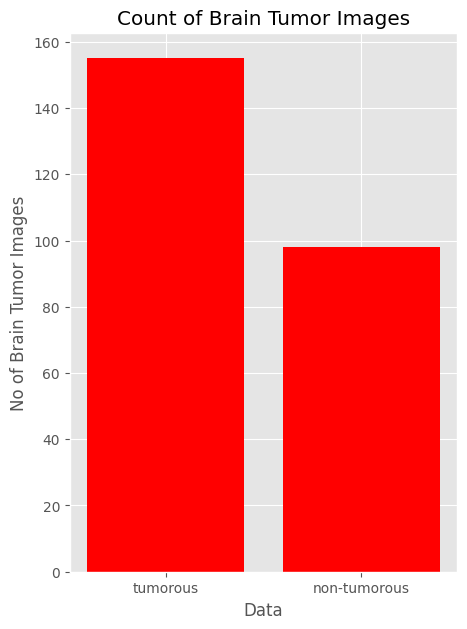

In [ ]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# Data Augmentation
## 155(61%), 98(39%)
## imbalance

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [ ]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [ ]:
import time
start_time = time.time()

yes_path = 'brain_tumor_dataset/yes'
no_path = 'brain_tumor_dataset/no'

augmented_data_path = '/kaggle/augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:27.15341019630432


In [ ]:
def data_summary(main_path):
    yes_path = "/kaggle/augmented_data/yes/"
    no_path = "/kaggle/augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [ ]:
data_summary(augmented_data_path)

Number of sample: 2065
1085 Number of positive sample in percentage: 52.54237288135593%
980 Number of negative sample in percentage: 47.45762711864407%


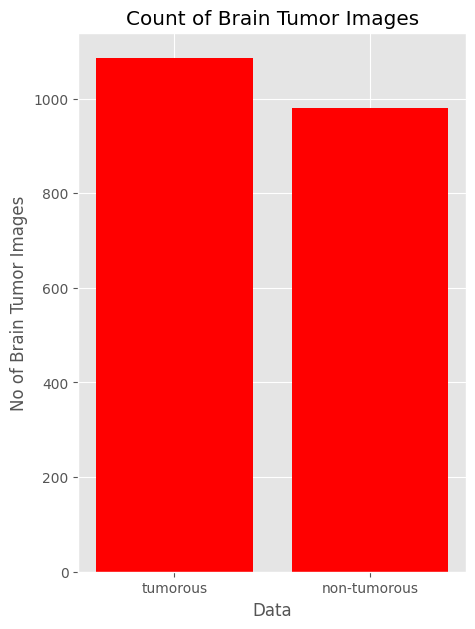

In [ ]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

##Data Preprocessing

In [ ]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0) #smothing the image

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1] # convert to binary
    thres =cv2.erode(thres, None, iterations = 2) # remove small noise
    thres = cv2.dilate(thres, None, iterations = 2) #expand the white region

    #Detect the boundaries
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image


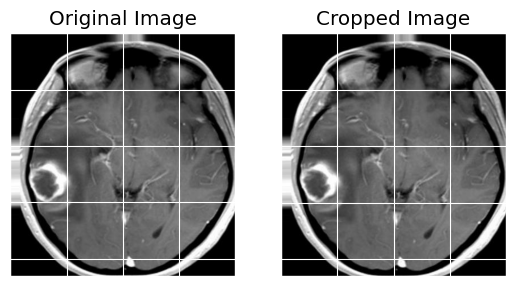

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
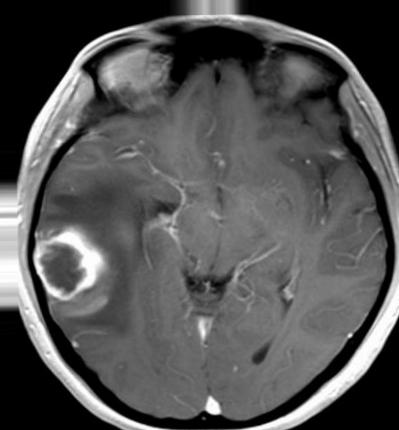

In [ ]:
img = cv2.imread('/kaggle/augmented_data/yes/aug_Y_100_0_1811.jpg')
crop_brain_tumor(img, True)

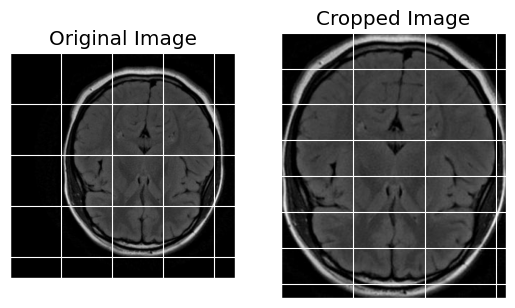

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
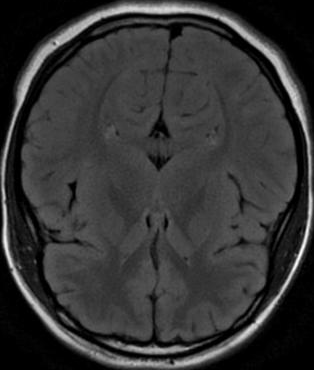

In [ ]:
img = cv2.imread('/kaggle/augmented_data/no/aug_N_10_0_1294.jpg')
crop_brain_tumor(img, True)

In [ ]:
#storing modified image to the same folder
folder1 = '/kaggle/augmented_data/no/'
folder2 ='/kaggle/augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

##Image Loading

In [ ]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y


In [ ]:
augmented_path = '/kaggle/augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 2065
X SHAPE is : (2065, 240, 240, 3)
y SHAPE is : (2065,)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Plotting the images

In [ ]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

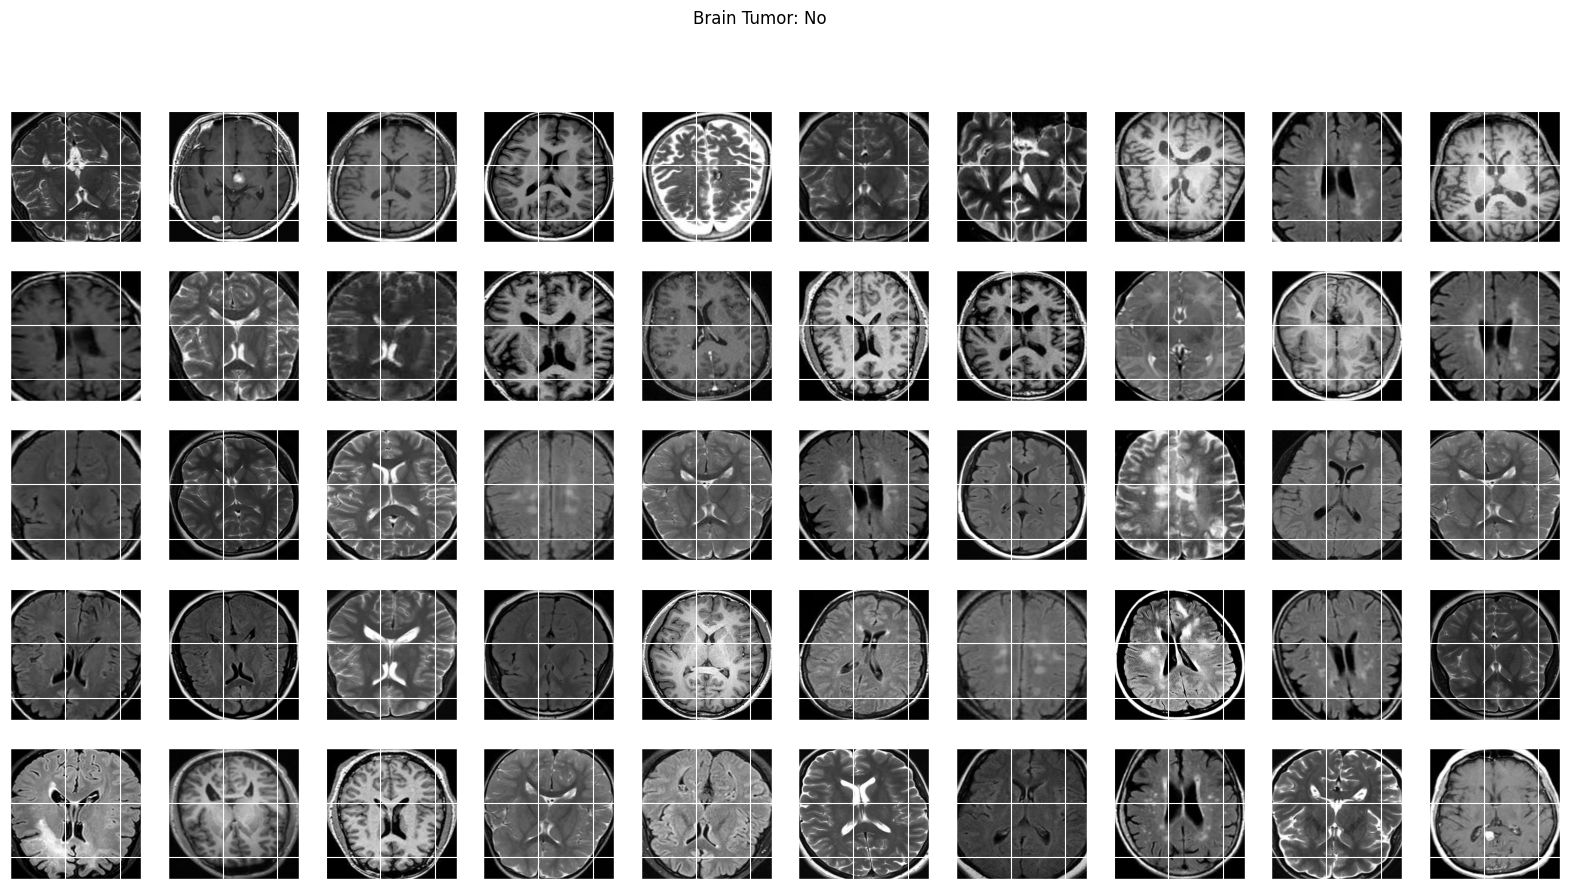

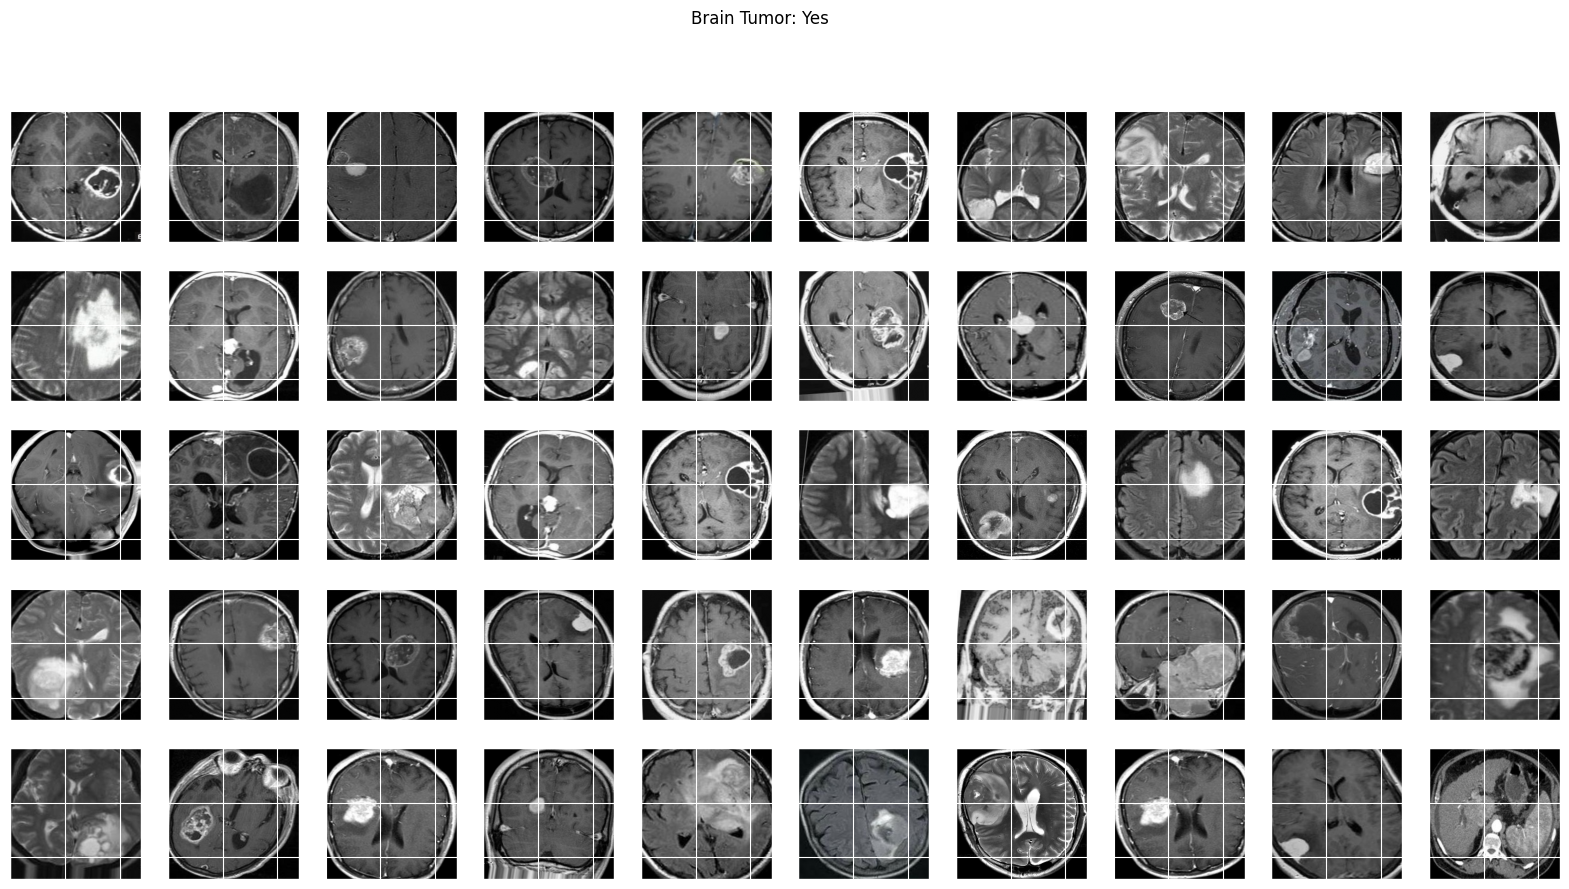

In [ ]:
plot_sample_images(X,y)

##Making directories to store data




In [ ]:
# making directories
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [ ]:
original_dataset_tumorours = os.path.join('/kaggle/augmented_data/','yes/')
original_dataset_nontumorours = os.path.join('/kaggle/augmented_data/','no/')

#Train Test and validation split
### 80% 10% 10%

In [ ]:
files = os.listdir('/kaggle/augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('/kaggle/augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:

files = os.listdir('/kaggle/augmented_data/yes/')
fnames = []
for i in range(922,1085):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('/kaggle/augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('/kaggle/augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('/kaggle/augmented_data/no/')
x=len(files)
fnames = []
for i in range(833,x):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

##Model building
### Model 1 using vgg19 (freezing all the previous parameters)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 1445 images belonging to 2 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 310 images belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 310 images belonging to 2 classes.


In [ ]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [ ]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [ ]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False #froze the model

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                              

###callback


In [ ]:
# callback
filepath = 'model.h5'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=5)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [ ]:
sgd = SGD(learning_rate=0.0001, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.7139 - accuracy: 0.5656
Epoch 1: val_loss improved from inf to 0.67989, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 22s 1s/step - loss: 0.7139 - accuracy: 0.5656 - val_loss: 0.6799 - val_accuracy: 0.5774 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.7112 - accuracy: 0.5344
Epoch 2: val_loss did not improve from 0.67989


10/10 [==============================] - 8s 881ms/step - loss: 0.7112 - accuracy: 0.5344 - val_loss: 0.7069 - val_accuracy: 0.5387 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.5700
Epoch 3: val_loss improved from 0.67989 to 0.67704, saving model to model.h5


10/10 [==============================] - 11s 1s/step - loss: 0.6953 - accuracy: 0.5700 - val_loss: 0.6770 - val_accuracy: 0.5710 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.6000
Epoch 4: val_loss did not improve from 0.67704


10/10 [==============================] - 9s 885ms/step - loss: 0.6810 - accuracy: 0.6000 - val_loss: 0.7325 - val_accuracy: 0.5032 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5750
Epoch 5: val_loss improved from 0.67704 to 0.64727, saving model to model.h5


10/10 [==============================] - 10s 1s/step - loss: 0.6937 - accuracy: 0.5750 - val_loss: 0.6473 - val_accuracy: 0.6226 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.6250
Epoch 6: val_loss improved from 0.64727 to 0.63635, saving model to model.h5


10/10 [==============================] - 10s 1s/step - loss: 0.6463 - accuracy: 0.6250 - val_loss: 0.6363 - val_accuracy: 0.6484 - lr: 1.0000e-04
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.6031
Epoch 7: val_loss improved from 0.63635 to 0.63533, saving model to model.h5


10/10 [==============================] - 10s 1s/step - loss: 0.6580 - accuracy: 0.6031 - val_loss: 0.6353 - val_accuracy: 0.6387 - lr: 1.0000e-04
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.5625
Epoch 8: val_loss did not improve from 0.63533


10/10 [==============================] - 9s 880ms/step - loss: 0.6600 - accuracy: 0.5625 - val_loss: 0.6404 - val_accuracy: 0.6484 - lr: 1.0000e-04
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.6466 - accuracy: 0.6375
Epoch 9: val_loss improved from 0.63533 to 0.62773, saving model to model.h5


10/10 [==============================] - 10s 1s/step - loss: 0.6466 - accuracy: 0.6375 - val_loss: 0.6277 - val_accuracy: 0.6452 - lr: 1.0000e-04
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.5973
Epoch 10: val_loss improved from 0.62773 to 0.62720, saving model to model.h5


10/10 [==============================] - 10s 1s/step - loss: 0.6549 - accuracy: 0.5973 - val_loss: 0.6272 - val_accuracy: 0.6548 - lr: 1.0000e-04


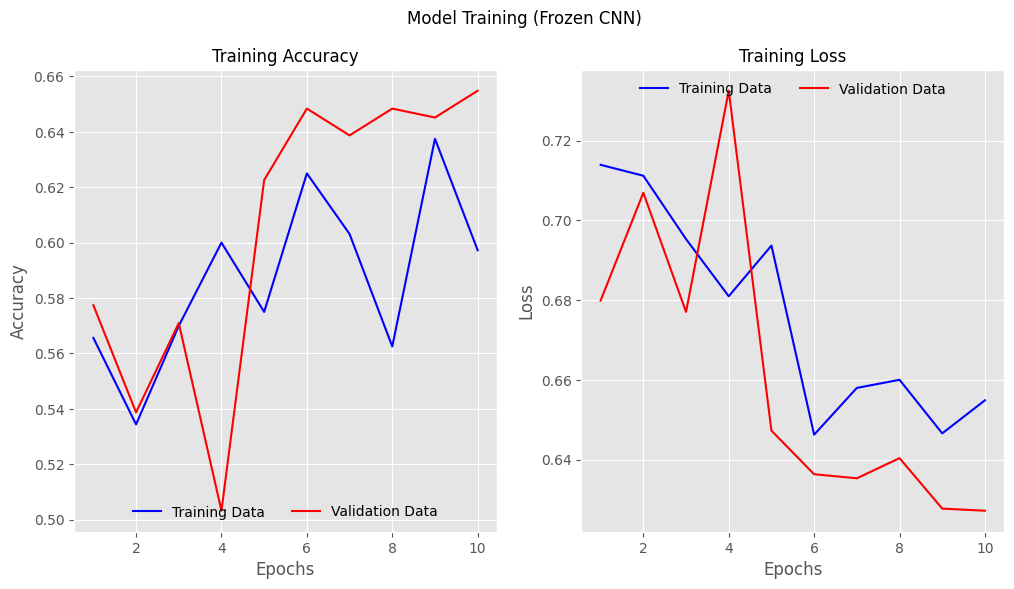

In [ ]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
#saving weight to use in 2nd model
model_01.save_weights(filepath="model_weights/vgg19_model_01.h5", overwrite=True)

In [ ]:
model_01.load_weights("model_weights/vgg19_model_01.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

10/10 [==============================] - 4s 398ms/step - loss: 0.6218 - accuracy: 0.6419


In [ ]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.628568708896637
Validation Acc: 0.64838707447052
Testing Loss: 0.6217702627182007
Testing Acc: 0.6419354677200317


In [ ]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=310, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

 10/310 [..............................] - ETA: 2:01

310/310 [==============================] - 4s 12ms/step


## Model 2
###unfreezing last two layer and using previous model parameters

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [ ]:
sgd = SGD(learning_rate=0.0001, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.6687
Epoch 1: val_loss improved from 0.62720 to 0.61694, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 12s 1s/step - loss: 0.5989 - accuracy: 0.6687 - val_loss: 0.6169 - val_accuracy: 0.6581 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.6594
Epoch 2: val_loss did not improve from 0.61694


10/10 [==============================] - 9s 889ms/step - loss: 0.6218 - accuracy: 0.6594 - val_loss: 0.6457 - val_accuracy: 0.6226 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6429 - accuracy: 0.6375
Epoch 3: val_loss did not improve from 0.61694


10/10 [==============================] - 9s 900ms/step - loss: 0.6429 - accuracy: 0.6375 - val_loss: 0.6217 - val_accuracy: 0.6419 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.6390 - accuracy: 0.6406
Epoch 4: val_loss improved from 0.61694 to 0.61254, saving model to model.h5


10/10 [==============================] - 10s 1s/step - loss: 0.6390 - accuracy: 0.6406 - val_loss: 0.6125 - val_accuracy: 0.6516 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.6266 - accuracy: 0.6485
Epoch 5: val_loss did not improve from 0.61254


10/10 [==============================] - 8s 846ms/step - loss: 0.6266 - accuracy: 0.6485 - val_loss: 0.6186 - val_accuracy: 0.6387 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.6750
Epoch 6: val_loss improved from 0.61254 to 0.60380, saving model to model.h5


10/10 [==============================] - 10s 1s/step - loss: 0.6098 - accuracy: 0.6750 - val_loss: 0.6038 - val_accuracy: 0.6903 - lr: 1.0000e-04
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.6438
Epoch 7: val_loss did not improve from 0.60380


10/10 [==============================] - 9s 885ms/step - loss: 0.6287 - accuracy: 0.6438 - val_loss: 0.6091 - val_accuracy: 0.6806 - lr: 1.0000e-04
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.6438
Epoch 8: val_loss did not improve from 0.60380


10/10 [==============================] - 9s 906ms/step - loss: 0.6209 - accuracy: 0.6438 - val_loss: 0.6057 - val_accuracy: 0.6645 - lr: 1.0000e-04
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.6263 - accuracy: 0.6625
Epoch 9: val_loss improved from 0.60380 to 0.58322, saving model to model.h5


10/10 [==============================] - 10s 1s/step - loss: 0.6263 - accuracy: 0.6625 - val_loss: 0.5832 - val_accuracy: 0.6903 - lr: 1.0000e-04
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.6656
Epoch 10: val_loss did not improve from 0.58322


10/10 [==============================] - 9s 902ms/step - loss: 0.5869 - accuracy: 0.6656 - val_loss: 0.5979 - val_accuracy: 0.6871 - lr: 1.0000e-04


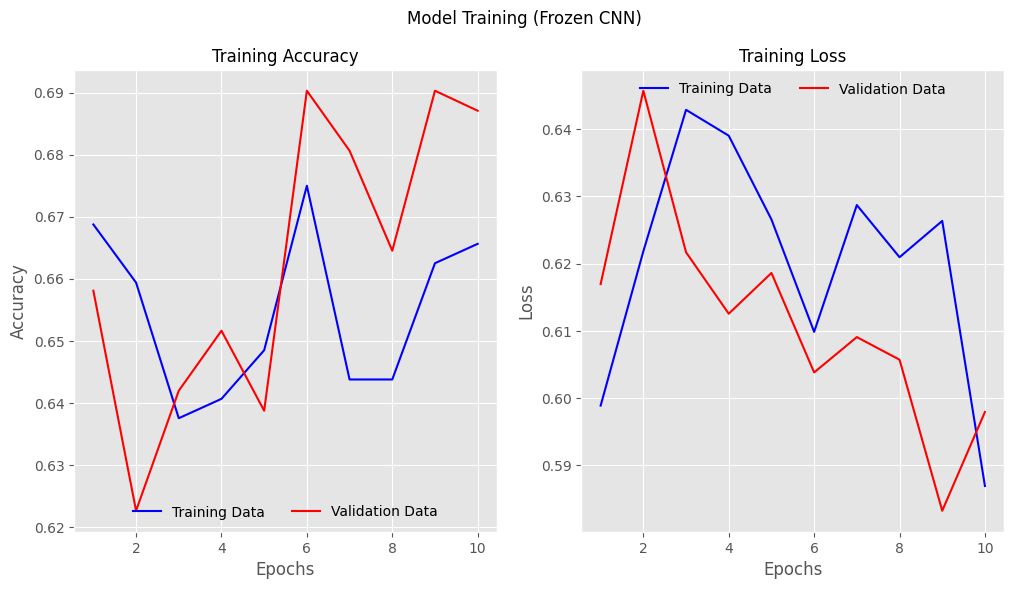

In [ ]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg19_model_02.h5", overwrite=True)

In [ ]:
model_02.load_weights("model_weights/vgg19_model_02.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

10/10 [==============================] - 4s 414ms/step - loss: 0.6258 - accuracy: 0.6355


##Model 3
#### Unfreezing the entire network and using model 2 weights

In [ ]:
# Unfreezing the entire network

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)


model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.h5')

sgd = SGD(learning_rate=0.0001, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
model_03.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [ ]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs = 17, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/17
10/10 [==============================] - ETA: 0s - loss: 0.6231 - accuracy: 0.6469
Epoch 1: val_loss did not improve from 0.58322


10/10 [==============================] - 20s 902ms/step - loss: 0.6231 - accuracy: 0.6469 - val_loss: 0.6573 - val_accuracy: 0.6194 - lr: 1.0000e-04
Epoch 2/17
10/10 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.6562
Epoch 2: val_loss improved from 0.58322 to 0.57927, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 11s 1s/step - loss: 0.5985 - accuracy: 0.6562 - val_loss: 0.5793 - val_accuracy: 0.6871 - lr: 1.0000e-04
Epoch 3/17
10/10 [==============================] - ETA: 0s - loss: 0.5775 - accuracy: 0.7000
Epoch 3: val_loss improved from 0.57927 to 0.55876, saving model to model.h5


10/10 [==============================] - 11s 1s/step - loss: 0.5775 - accuracy: 0.7000 - val_loss: 0.5588 - val_accuracy: 0.7129 - lr: 1.0000e-04
Epoch 4/17
10/10 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7625
Epoch 4: val_loss did not improve from 0.55876


10/10 [==============================] - 9s 899ms/step - loss: 0.5459 - accuracy: 0.7625 - val_loss: 0.5723 - val_accuracy: 0.7032 - lr: 1.0000e-04
Epoch 5/17
10/10 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.7156
Epoch 5: val_loss improved from 0.55876 to 0.54988, saving model to model.h5


10/10 [==============================] - 11s 1s/step - loss: 0.5451 - accuracy: 0.7156 - val_loss: 0.5499 - val_accuracy: 0.7129 - lr: 1.0000e-04
Epoch 6/17
10/10 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.7469
Epoch 6: val_loss improved from 0.54988 to 0.52603, saving model to model.h5


10/10 [==============================] - 11s 1s/step - loss: 0.5495 - accuracy: 0.7469 - val_loss: 0.5260 - val_accuracy: 0.7355 - lr: 1.0000e-04
Epoch 7/17
10/10 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.7133
Epoch 7: val_loss improved from 0.52603 to 0.51835, saving model to model.h5


10/10 [==============================] - 12s 1s/step - loss: 0.5490 - accuracy: 0.7133 - val_loss: 0.5183 - val_accuracy: 0.7226 - lr: 1.0000e-04
Epoch 8/17
10/10 [==============================] - ETA: 0s - loss: 0.5107 - accuracy: 0.7719
Epoch 8: val_loss improved from 0.51835 to 0.48164, saving model to model.h5


10/10 [==============================] - 11s 1s/step - loss: 0.5107 - accuracy: 0.7719 - val_loss: 0.4816 - val_accuracy: 0.7839 - lr: 1.0000e-04
Epoch 9/17
10/10 [==============================] - ETA: 0s - loss: 0.5090 - accuracy: 0.7469
Epoch 9: val_loss did not improve from 0.48164


10/10 [==============================] - 9s 890ms/step - loss: 0.5090 - accuracy: 0.7469 - val_loss: 0.4851 - val_accuracy: 0.7871 - lr: 1.0000e-04
Epoch 10/17
10/10 [==============================] - ETA: 0s - loss: 0.5296 - accuracy: 0.7219
Epoch 10: val_loss improved from 0.48164 to 0.46331, saving model to model.h5


10/10 [==============================] - 10s 1s/step - loss: 0.5296 - accuracy: 0.7219 - val_loss: 0.4633 - val_accuracy: 0.8032 - lr: 1.0000e-04
Epoch 11/17
10/10 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.7531
Epoch 11: val_loss improved from 0.46331 to 0.45472, saving model to model.h5


10/10 [==============================] - 11s 1s/step - loss: 0.4967 - accuracy: 0.7531 - val_loss: 0.4547 - val_accuracy: 0.8065 - lr: 1.0000e-04
Epoch 12/17
10/10 [==============================] - ETA: 0s - loss: 0.4749 - accuracy: 0.7750
Epoch 12: val_loss did not improve from 0.45472


10/10 [==============================] - 9s 886ms/step - loss: 0.4749 - accuracy: 0.7750 - val_loss: 0.4555 - val_accuracy: 0.7839 - lr: 1.0000e-04
Epoch 13/17
10/10 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.7969
Epoch 13: val_loss improved from 0.45472 to 0.44874, saving model to model.h5


10/10 [==============================] - 11s 1s/step - loss: 0.4509 - accuracy: 0.7969 - val_loss: 0.4487 - val_accuracy: 0.7806 - lr: 1.0000e-04
Epoch 14/17
10/10 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.7688
Epoch 14: val_loss improved from 0.44874 to 0.41356, saving model to model.h5


10/10 [==============================] - 11s 1s/step - loss: 0.4626 - accuracy: 0.7688 - val_loss: 0.4136 - val_accuracy: 0.8226 - lr: 1.0000e-04
Epoch 15/17
10/10 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8031
Epoch 15: val_loss improved from 0.41356 to 0.37905, saving model to model.h5


10/10 [==============================] - 11s 1s/step - loss: 0.4382 - accuracy: 0.8031 - val_loss: 0.3791 - val_accuracy: 0.8355 - lr: 1.0000e-04
Epoch 16/17
10/10 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.8281
Epoch 16: val_loss improved from 0.37905 to 0.34797, saving model to model.h5


10/10 [==============================] - 11s 1s/step - loss: 0.4053 - accuracy: 0.8281 - val_loss: 0.3480 - val_accuracy: 0.8516 - lr: 1.0000e-04
Epoch 17/17
10/10 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.7812
Epoch 17: val_loss did not improve from 0.34797


10/10 [==============================] - 9s 903ms/step - loss: 0.4399 - accuracy: 0.7812 - val_loss: 0.3480 - val_accuracy: 0.8645 - lr: 1.0000e-04


In [ ]:
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

10/10 [==============================] - 4s 408ms/step - loss: 0.3696 - accuracy: 0.8484


In [ ]:
model_03.save_weights(filepath="model_weights/vgg19_model_03.h5", overwrite=True)
model_03.save('model_weights/vgg19_model1_03.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Test MRI image of my father that i captured almost 3 years ago

1/1 [==============================] - 0s 182ms/step


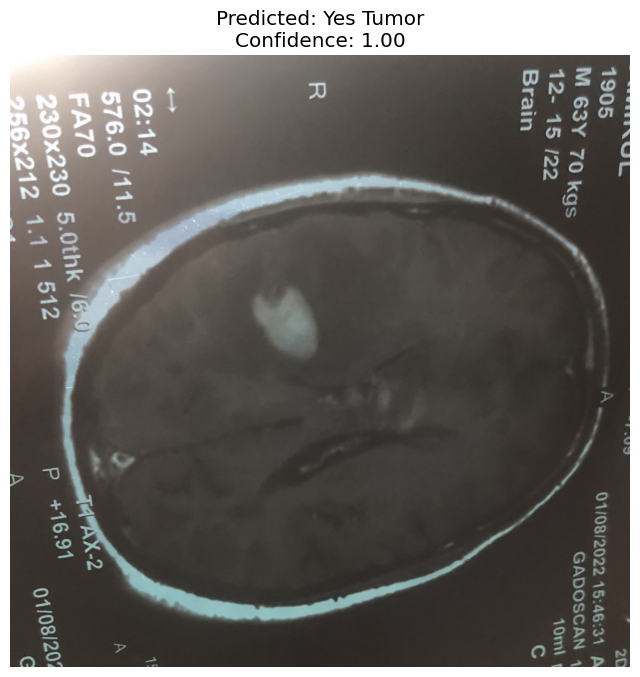

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load your model
model = tf.keras.models.load_model('model_weights/vgg19_model1_03.h5')

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Path to the downloaded image
img_path = '/content/yes/IMG_0205 2.jpg'

# Preprocess the image
input_shape = (240, 240)  # Update this if your model has a different input shape
img_array = preprocess_image(img_path, target_size=input_shape)

# Predict using the model
predictions = model.predict(img_array)

# Decode the predictions
predicted_class = np.argmax(predictions, axis=1)
confidence = np.max(predictions)
class_labels = ['No tumor', 'Yes Tumor']  # Replace with your actual class labels
predicted_label = class_labels[predicted_class[0]]

# Display the image along with the prediction and confidence level
plt.figure(figsize=(8, 8))
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {predicted_label}\nConfidence: {confidence:.2f}')
plt.show()



```
# This is formatted as code
```

#Model 4.
##Model with Adam optimizer and Unfreezing the entire network

###did not perform well

In [ ]:
from keras.optimizers import Adam
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_04 = Model(base_model.inputs, output)
model_04.load_weights('model_weights/vgg19_model_03.h5')
adam = Adam(learning_rate=0.0001)
model_04.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

In [ ]:
history_04 = model_04.fit(train_generator, steps_per_epoch=10, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.9320 - accuracy: 0.5344
Epoch 1: val_loss did not improve from 0.34797


10/10 [==============================] - 15s 900ms/step - loss: 1.9320 - accuracy: 0.5344 - val_loss: 0.6935 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.4969
Epoch 2: val_loss did not improve from 0.34797


10/10 [==============================] - 9s 896ms/step - loss: 0.6942 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4676
Epoch 3: val_loss did not improve from 0.34797


10/10 [==============================] - 8s 843ms/step - loss: 0.6932 - accuracy: 0.4676 - val_loss: 0.6932 - val_accuracy: 0.4742 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5094
Epoch 4: val_loss did not improve from 0.34797


10/10 [==============================] - 9s 885ms/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6931 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4983
Epoch 5: val_loss did not improve from 0.34797


10/10 [==============================] - 8s 844ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6929 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5031
Epoch 6: val_loss did not improve from 0.34797


10/10 [==============================] - 9s 892ms/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6930 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5562
Epoch 7: val_loss did not improve from 0.34797


10/10 [==============================] - 9s 883ms/step - loss: 0.6927 - accuracy: 0.5562 - val_loss: 0.6928 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5469
Epoch 8: val_loss did not improve from 0.34797


10/10 [==============================] - 9s 892ms/step - loss: 0.6924 - accuracy: 0.5469 - val_loss: 0.6926 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5813
Epoch 9: val_loss did not improve from 0.34797


10/10 [==============================] - 9s 878ms/step - loss: 0.6908 - accuracy: 0.5813 - val_loss: 0.6923 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.5392
Epoch 10: val_loss did not improve from 0.34797


10/10 [==============================] - 8s 847ms/step - loss: 0.6915 - accuracy: 0.5392 - val_loss: 0.6921 - val_accuracy: 0.5258 - lr: 1.0000e-04


##Hyper parameter tuning

In [ ]:
!pip install tensorflow keras keras-tuner

###Creating fuction to define Model and Hyperparameters

In [ ]:
from keras.applications import VGG19, ResNet50, InceptionV3, EfficientNetB0
import keras_tuner as kt
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

def build_model(hp, base_model_name):
    if base_model_name == 'VGG19':
        base_model = VGG19(include_top=False, input_shape=(240, 240, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, input_shape=(240, 240, 3))
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(include_top=False, input_shape=(240, 240, 3))
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(include_top=False, input_shape=(240, 240, 3))
    else:
        raise ValueError("Unsupported base model name")

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Tune the number of units in the Dense layers
    class_1_units = hp.Int('class_1_units', min_value=1024, max_value=4608, step=512)
    class_2_units = hp.Int('class_2_units', min_value=256, max_value=1152, step=128)

    class_1 = Dense(class_1_units, activation='relu')(x)
    drop_out = Dropout(hp.Float('drop_out_rate', 0.2, 0.5, step=0.1))(class_1)
    class_2 = Dense(class_2_units, activation='relu')(drop_out)
    output = Dense(2, activation='softmax')(class_2)

    model = Model(base_model.inputs, output)

    # Tune the learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


##Tuner setup

###ResNet50 and EfficientNetB0

In [ ]:
base_model_ResNet50 = 'ResNet50'  #'InceptionV3', or 'EfficientNetB0'
base_model_EfficientNetB0 = 'EfficientNetB0'

tuner1 = kt.Hyperband(
    lambda hp: build_model(hp, base_model_ResNet50),
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='my_dir',
    project_name=f'brain_tumor_{base_model_ResNet50}'
)




#Tuner for EfficientNetB0
# Bayesian Optimization
tuner2 = kt.BayesianOptimization(
    lambda hp: build_model(hp, base_model_EfficientNetB0),
    objective='val_accuracy',
    max_trials=5,  # limit the number of trials
    executions_per_trial=1,
    directory='my_dir',
    project_name=f'brain_tumor_{base_model_EfficientNetB0}'
)

Reloading Tuner from my_dir/brain_tumor_ResNet50/tuner0.json


##Prepare the Data Generators

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/tumorous_and_nontumorous/train/',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/tumorous_and_nontumorous/valid/',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

Found 1445 images belonging to 2 classes.
Found 310 images belonging to 2 classes.


##Perform Hyperparameter Tuning:

In [ ]:
# for EfficientNetB0
tuner2.search(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001),
               EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)]
)

# Get the optimal hyperparameters
best_hps = tuner2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first dense layer is {best_hps.get('class_1_units')}.
The optimal number of units in the second dense layer is {best_hps.get('class_2_units')}.
The optimal dropout rate is {best_hps.get('drop_out_rate')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 5 Complete [00h 01m 46s]
val_accuracy: 0.5258064270019531

Best val_accuracy So Far: 0.5258064270019531
Total elapsed time: 00h 09m 18s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
4096              |2560              |class_1_units
512               |768               |class_2_units
0.4               |0.2               |drop_out_rate
0.01              |0.001             |learning_rate

Epoch 1/5
26/46 [===============>..............] - ETA: 7s - loss: 7.4886 - accuracy: 0.5024

KeyboardInterrupt: 

In [ ]:
# for ResNet50
tuner1.search(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001),
               EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)]
)

# Get the optimal hyperparameters
best_hps = tuner2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first dense layer is {best_hps.get('class_1_units')}.
The optimal number of units in the second dense layer is {best_hps.get('class_2_units')}.
The optimal dropout rate is {best_hps.get('drop_out_rate')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 10 Complete [00h 01m 43s]
val_accuracy: 0.5258064270019531

Best val_accuracy So Far: 0.5838709473609924
Total elapsed time: 00h 34m 32s

The optimal number of units in the first dense layer is 2560.
The optimal number of units in the second dense layer is 768.
The optimal dropout rate is 0.2.
The optimal learning rate for the optimizer is 0.001.



##Model 5
### model training for ResNet50 with hyperparameter tuning weight

In [ ]:
model = tuner1.hypermodel.build(best_hps)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001),
               EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)]
)

Epoch 1/10
46/46 [==============================] - 24s 434ms/step - loss: 0.9507 - accuracy: 0.5017 - val_loss: 0.6928 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 2/10
46/46 [==============================] - 19s 418ms/step - loss: 0.7077 - accuracy: 0.5107 - val_loss: 0.7271 - val_accuracy: 0.4742 - lr: 0.0010
Epoch 3/10
46/46 [==============================] - 19s 420ms/step - loss: 0.7111 - accuracy: 0.5135 - val_loss: 0.6932 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.7043 - accuracy: 0.5183
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
46/46 [==============================] - 19s 410ms/step - loss: 0.7043 - accuracy: 0.5183 - val_loss: 0.6941 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 5/10
46/46 [==============================] - 19s 411ms/step - loss: 0.6907 - accuracy: 0.5183 - val_loss: 0.6907 - val_accuracy: 0.5516 - lr: 5.0000e-04
Epoch 6/10
46/46 [==============================] - 19s 4

##Model 6
###manually Adding 4 dense layer for ResNet50

In [ ]:
# Manually setting the hyperparameters
best_hps = {
    'class_1_units': 4096,
    'class_2_units': 2560,
    'class_3_units': 2560,
    'class_4_units': 768,
    'drop_out_rate': 0.3,
    'learning_rate': 1e-3
}

# Load the ResNet50 model
base_model = ResNet50(include_top=False, input_shape=(240, 240, 3))

# Add Global Average Pooling
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add dense layers
x = Dense(best_hps['class_1_units'], activation='relu')(x)
x = Dropout(best_hps['drop_out_rate'])(x)
x = Dense(best_hps['class_2_units'], activation='relu')(x)
x = Dropout(best_hps['drop_out_rate'])(x)
x = Dense(best_hps['class_3_units'], activation='relu')(x)
x = Dropout(best_hps['drop_out_rate'])(x)
x = Dense(best_hps['class_4_units'], activation='relu')(x)
x = Dropout(best_hps['drop_out_rate'])(x)
output = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.inputs, outputs=output)

# Compile the model
model.compile(optimizer=sgd(learning_rate=best_hps['learning_rate']),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
#model.summary()

# Define the data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/tumorous_and_nontumorous/train/',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/tumorous_and_nontumorous/valid/',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001),
        EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    ]
)


Found 1445 images belonging to 2 classes.
Found 310 images belonging to 2 classes.
Epoch 1/5
46/46 [==============================] - 50s 434ms/step - loss: 0.9818 - accuracy: 0.5744 - val_loss: 408.8448 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - 19s 413ms/step - loss: 0.6400 - accuracy: 0.6401 - val_loss: 3257.5735 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - 19s 408ms/step - loss: 0.5187 - accuracy: 0.7619 - val_loss: 5368.6553 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - 19s 417ms/step - loss: 0.4902 - accuracy: 0.7931 - val_loss: 313.6397 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 5/5
46/46 [==============================] - 20s 420ms/step - loss: 0.4839 - accuracy: 0.8007 - val_loss: 132.7462 - val_accuracy: 0.5258 - lr: 0.0010


In [ ]:
restnet_val_eval_05 = model.evaluate(valid_generator)
restnet_test_eval_03 = model.evaluate(test_generator)

10/10 [==============================] - 4s 405ms/step - loss: 135.6455 - accuracy: 0.5258


##Model 7
###Manually adding only two dense layer in ResNet50

In [ ]:
import tensorflow as tf
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

# Clear any previous session to free up memory
tf.keras.backend.clear_session()

# Load the ResNet50 model, excluding the top dense layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce the tensor dimensions

# Add a fully-connected layer with ReLU activation
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting

# Add another fully-connected layer with ReLU activation
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Finally, add a softmax layer for classification (assuming binary classification)
output = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the layers of the base model (optional, can be tuned later)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can train your model with your dataset
model.fit(train_generator, epochs=10, validation_data=validation_generator, batch_size=32)

Epoch 1/10
46/46 [==============================] - 27s 435ms/step - loss: 0.9875 - accuracy: 0.4775 - val_loss: 0.7262 - val_accuracy: 0.5258
Epoch 2/10
46/46 [==============================] - 19s 409ms/step - loss: 0.7336 - accuracy: 0.5045 - val_loss: 0.6969 - val_accuracy: 0.4774
Epoch 3/10
46/46 [==============================] - 19s 404ms/step - loss: 0.7159 - accuracy: 0.5073 - val_loss: 0.6969 - val_accuracy: 0.5258
Epoch 4/10
46/46 [==============================] - 19s 406ms/step - loss: 0.7037 - accuracy: 0.4990 - val_loss: 0.6957 - val_accuracy: 0.5258
Epoch 5/10
46/46 [==============================] - 19s 405ms/step - loss: 0.6991 - accuracy: 0.5211 - val_loss: 0.6973 - val_accuracy: 0.5258
Epoch 6/10
46/46 [==============================] - 19s 405ms/step - loss: 0.6960 - accuracy: 0.5204 - val_loss: 0.6943 - val_accuracy: 0.5258
Epoch 7/10
46/46 [==============================] - 19s 405ms/step - loss: 0.6961 - accuracy: 0.5093 - val_loss: 0.6932 - val_accuracy: 0.5258

##Model Ensembling.
### couldn't do that because my other model accurecy isn't good